<a href="https://colab.research.google.com/github/HyunMiPark/study_AI/blob/main/%5B3%EC%A3%BC%EC%B0%A8%5D_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

```markdown
### 과제 요구 사항들을 구현하고, epoch마다의 train loss와 최종 모델의 test accuracy가 print된 notebook을 public github repository에 업로드하여 공유해주시면 됩니다. 반드시 출력 결과가 남아있어야 합니다.
- [ ] AG_News dataset 준비
	- Huggingface dataset의 `fancyzhx/ag_news`를 load
	- `collate_fn` 함수에 다음 수정사항들을 반영
    - Truncation과 관련된 부분들을 삭제
- [ ] Classifier output, loss function, accuracy function 변경
	- 뉴스 기사 분류 문제는 binary classification이 아닌 일반적인 classification 문제입니다. MNIST 과제에서 했던 것 처럼 `nn.CrossEntropyLoss` 를 추가하고 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정
	- 그리고 정확도를 재는 `accuracy` 함수도 classification에 맞춰 수정
- [ ]  학습 결과 report
    - DistilBERT 실습과 같이 매 epoch 마다의 train loss를 출력하고 최종 모델의 test accuracy를 report 첨부
  
- [x] 완료된 항목은 체크박스에 x 표시

- 이미지 첨부시 : ![이미지 설명](경로) / 예시: ![poster](./image.png)

```

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [6]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [9]:
# IMDB 감정 분석 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

#첫번째 샘플 데이터 확인
print("train sample: ", train_ds[0])
print("test sample:", test_ds[0])

#샘플 개수 확인
print("train sample count: ", len(train_ds))
print("test sample count: ", len(test_ds))

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(tokenizer(texts, padding=True).input_ids)
    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

train sample:  {'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
test sample: {'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'label': 2}
train sample count:  6000
test sample count:  380


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [10]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [11]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')


        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [12]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [15]:
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

#학습 과정 시각화 함수
def plot_acc(train_accs, test_accs):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label='train') #학습 데이터 정확도 그래프
  plt.plot(x, test_accs, label='test') #테스트 데이터 정확도 그래프
  plt.legend()
  plt.show()


Epoch   0 | Train Loss: 44.17447881400585
Epoch   1 | Train Loss: 43.279855728149414
Epoch   2 | Train Loss: 42.3982077986002
Epoch   3 | Train Loss: 42.11582839488983
Epoch   4 | Train Loss: 41.91122090816498
Epoch   5 | Train Loss: 40.84867951273918
Epoch   6 | Train Loss: 41.43193298578262
Epoch   7 | Train Loss: 40.47957889735699
Epoch   8 | Train Loss: 40.364510640501976
Epoch   9 | Train Loss: 39.32544666528702
Epoch  10 | Train Loss: 40.109224393963814
Epoch  11 | Train Loss: 38.99201110005379
Epoch  12 | Train Loss: 40.28619630634785
Epoch  13 | Train Loss: 39.377694860100746
Epoch  14 | Train Loss: 38.90392646193504
Epoch  15 | Train Loss: 38.77551767230034
Epoch  16 | Train Loss: 38.2272524535656
Epoch  17 | Train Loss: 38.48647375404835
Epoch  18 | Train Loss: 37.5396938174963
Epoch  19 | Train Loss: 38.16238744556904
Epoch  20 | Train Loss: 37.555026575922966
Epoch  21 | Train Loss: 37.46879830956459
Epoch  22 | Train Loss: 37.512768626213074
Epoch  23 | Train Loss: 37.1730

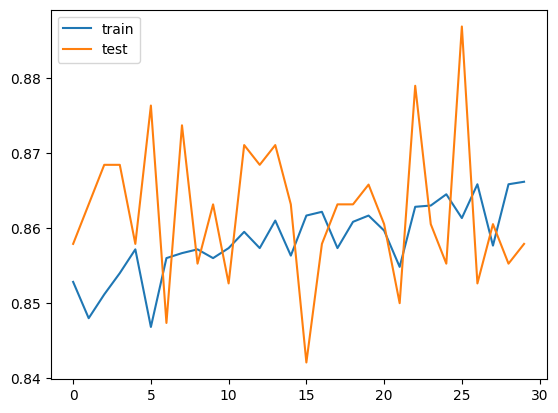

In [17]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
train_acc= []
test_acc = []

n_epochs = 30

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # loss 누적

    train_acc.append(accuracy(model, train_loader))
    test_acc.append(accuracy(model, test_loader))
    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")


plot_acc(train_acc, test_acc) #학습 결과 시각화

In [18]:

# 평가 시 gradient 계산 비활성화
with torch.no_grad():
    model.eval()  # 평가 모드로 전환 (계산 비활성화)
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


=========> Train acc: 0.876 | Test acc: 0.868
